In [1]:
%pylab inline
import cv2

Populating the interactive namespace from numpy and matplotlib


# Segmentación de Imágenes Usando la Transformada Watershed

La *Transformada Watershed* es un algortimo que permite realizar segmentación de imágenes. Así como el algoritmo Canny que trabajamos la clase pasada, es un paso preliminar a la aplicación de la transformada de Hough para la parametrización de los segmentos identificados.  

En la sección 11.5 del libro Digital Image Processing using Matlab de Gonzalez, Woods y Eddings que les subí a Sicua+ (les subí la versión de una versión más actual que la que había subido el lunes) encuentran una descripción del método y cómo implementarlo en Matlab. El objetivo de este taller es familiarizarse con algunos de los algoritmos de procesamiento de imágenes que permiten segmentar y parametrizar características de imágenes con el fin de desarrollar un método de granulometría de metales.  

Con el fin de satisfacer los objetivos planteados se le pide:  

* Leer el archivo de granulometría que va a analizar.  
* Reproducir el resultado mostrado en la Figura 11.28 de la referencia utilizando la herramienta OpenCV. Para esto se recomienda inicialmente revisar y reproducir:  
    * https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv  
    * https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html  
* Ajustar el procedimiento para que segmente eficientemente las imágenes de granulometría.  
* Aplicar la transformada de Hough para parametrizar los segmentos identificados. Para esto se recomienda probar con círculos o elípses para determinar cuál tiene un mejor rendimiento.  
* Extraer la distribución de diámetros de los granos identificados.  
* Generar un histograma de la distribución de tamaño de grano encontrado.  

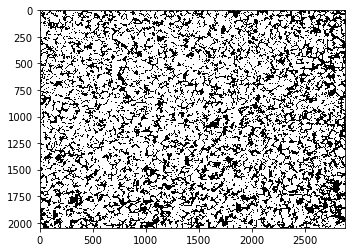

In [2]:
imgOrg=cv2.imread('200x_1010_T.tif')
imgOrg=cv2.cvtColor(imgOrg,cv2.COLOR_RGB2GRAY)
plt.imshow(imgOrg,'gray')
ret,thresh1=cv2.threshold(imgOrg,180,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,'gray')

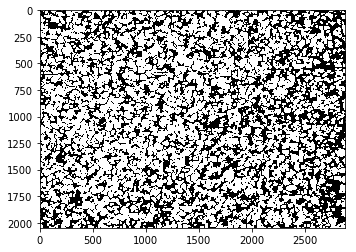

In [39]:
kernel = np.ones((10,10),np.uint8)
opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
plt.imshow(opening,'gray')

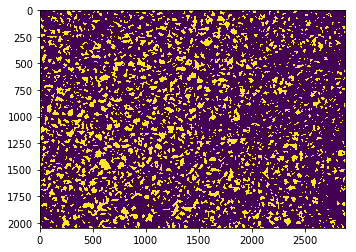

In [42]:
#sure background
surebg=cv2.dilate(opening,kernel,iterations=1)
#
dist=cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret2,surefg=cv2.threshold(dist,.2*dist.max(),255,cv2.THRESH_BINARY)
plt.imshow(surefg)

2189


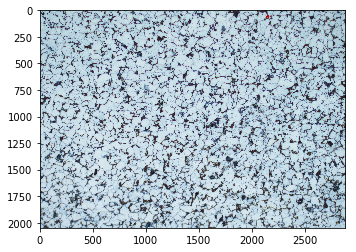

In [66]:
surefg=np.uint8(surefg)
unknown=cv2.subtract(surebg,surefg)

ret,markers=cv2.connectedComponents(surefg)

markers=markers+1
print(markers.max())
markers[unknown==255]=0
markers=markers.astype('int32')


im=cv2.imread('200x_1010_T.tif')
m=cv2.watershed(im,markers)
#plt.imshow(m)

grano20=m
im2=im.copy()
im2[m==100]=(200,0,0)
plt.imshow(im2)

In [67]:
m

array([[  -1,   -1,   -1, ...,   -1,   -1,   -1],
       [  -1,    1,    1, ...,    1,    1,   -1],
       [  -1,    1,    1, ...,    1,    1,   -1],
       ...,
       [  -1, 2161, 2161, ..., 2147, 2147,   -1],
       [  -1, 2161, 2161, ..., 2147, 2147,   -1],
       [  -1,   -1,   -1, ...,   -1,   -1,   -1]])